In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## run trec eval commands

In [3]:
# 
qual_qrels = '.\\qrels\\touche-task1-2022-quality-dedup.qrels'
coh_qrels = '.\\qrels\\touche-task1-2022-coherence-dedup.qrels'
rele_qrels = '.\\qrels\\touche-task1-2022-relevance-dedup.qrels'

# Modify this line to take into account were you have trec_eval.exe, this could have been added to the path and then it would have been used just trec_command = "trec_eval.exe" but I preferred this way.
trec_command = 'C:\\Users\\mari8\\OneDrive\\Desktop\\università\\magistrale\\SE\\trec_eval\\trec_eval.exe'

runs_dir = '.\\runs'
res_dir = '.\\results'

# This is to make sure you are running the script in the correct directory, modify this line to take into account your system.
os.chdir("C:\\Users\\mari8\\seupd2122-6musk")

In [5]:
# Evaluate all the runs for this year's topics using this year relevance judgments
runs_to_process = os.listdir(runs_dir)
for item in runs_to_process:
    if not os.path.isfile(os.path.join(runs_dir, item)):
        continue
    command_quality = '{command} -q -m all_trec {qrels} {runs_dir}\\{run} > {res_dir}\\{name_p1}-quality-res.txt'.format(command=trec_command, qrels=qual_qrels, run=item, runs_dir=runs_dir, res_dir=res_dir, name_p1=re.search('(.+)\.(.+)', item).group(1))
    command_relevance = '{command} -q -m all_trec {qrels} {runs_dir}\\{run} > {res_dir}\\{name_p1}-relevance-res.txt'.format(command=trec_command, qrels=rele_qrels, run=item, runs_dir=runs_dir, res_dir=res_dir, name_p1=re.search('(.+)\.(.+)', item).group(1))
    command_coherence = '{command} -q -m all_trec {qrels} {runs_dir}\\{run} > {res_dir}\\{name_p1}-coherence-res.txt'.format(command=trec_command, qrels=coh_qrels, run=item, runs_dir=runs_dir, res_dir=res_dir, name_p1=re.search('(.+)\.(.+)', item).group(1))
    
    os.system(command_quality)
    os.system(command_relevance)
    os.system(command_coherence)


In [6]:
# function used to retrieve all results and return them as Dataframes  

def get_results_runs(res_dir_1, judg):
    # judg is 'quality', 'relevance' or 'coherence'

    values_map_ndcg_cut_5 = []
    values_ipr = []

    runs_to_process = os.listdir(runs_dir)
    for item in runs_to_process:
        if not os.path.isfile(os.path.join(runs_dir, item)):
            continue
            
        current_filename = '{res_dir}\\{name_p1}-{type_res}-res.txt'.format(res_dir=res_dir, name_p1=re.search('(.+)\.(.+)', item).group(1), type_res=judg)
        
        # Skip empty runs
        try:
            if os.path.getsize(current_filename) == 0:
                continue
        except WindowsError:
            continue

        # Parse files searching for the 
        value_runid = '' 
        value_ndcg_cut_5 = 0.0
        value_map = 0.0
        value_iprec_at_recall = []

        for line in open(current_filename):
            res_runid = re.search('^runid\s+all\s+(.+)', line)
            res_map = re.search('^map\s+all\s+(\d.\d+)', line)
            res_ndcg_cut_5 = re.search('^ndcg_cut_5\s+all\s+(\d.\d+)', line)
            res_iprec_at_recall_ = re.search('^iprec_at_recall_(\d.\d+)\s+all\s+(\d.\d+)', line)

            if res_runid:   
                value_runid = res_runid.group(1)  
            if res_map:
                value_map = float(res_map.group(1)) 
            if res_ndcg_cut_5:
                value_ndcg_cut_5 = float(res_ndcg_cut_5.group(1))
            if res_iprec_at_recall_:
                #print(res_iprec_at_recall_.group(1) + ' ' + res_iprec_at_recall_.group(2))
                value_iprec_at_recall.append(float(res_iprec_at_recall_.group(2)))
            #print(line.strip('\n') + ' and file: ' + current_filename)

        values_map_ndcg_cut_5.append([value_runid, value_map, value_ndcg_cut_5])
        values_ipr.append([*[value_runid], *value_iprec_at_recall])
        #print(value_runid + ', map: ' + str(value_map) + ', ndcg_cut_5: ' + str(value_ndcg_cut_5))
        #print(value_iprec_at_recall)
    
    df_map_and_ndcg_cut_5 = pd.DataFrame(values_map_ndcg_cut_5, columns=['runid', 'map', 'ndcg_cut_5'])
    df_ipr = df = pd.DataFrame(values_ipr, columns=['runid', 'ipr0.0','ipr0.1','ipr0.2','ipr0.3','ipr0.4','ipr0.5','ipr0.6','ipr0.7','ipr0.8','ipr0.9', 'ipr1.0'])

    return df_map_and_ndcg_cut_5, df_ipr

## TABLES

### table for ndcg, iprec@rec for quality qrels

In [29]:
df_map_and_ndcg_cut_5, df_ipr = get_results_runs(res_dir, 'quality')
df_map_and_ndcg_cut_5

runid     map  ndcg_cut_5
0           seupd2122-6musk-kstem-stop-shingle3  0.0397      0.7258
1              seupd2122-6musk-stop-kstem-basic  0.0162      0.2876
2         seupd2122-6musk-stop-kstem-concsearch  0.0482      0.7244
3  seupd2122-6musk-stop-wordnet-kstem-dirichlet  0.0470      0.7299
4      seupd2122-6musk-word2vec-sentences-kstem  0.0463      0.7183

In [30]:
df_ipr

runid  ipr0.0  ipr0.1  ipr0.2  \
0           seupd2122-6musk-kstem-stop-shingle3  0.9507  0.0000     0.0   
1              seupd2122-6musk-stop-kstem-basic  0.5742  0.0000     0.0   
2         seupd2122-6musk-stop-kstem-concsearch  0.9727  0.0127     0.0   
3  seupd2122-6musk-stop-wordnet-kstem-dirichlet  0.9735  0.0096     0.0   
4      seupd2122-6musk-word2vec-sentences-kstem  0.9495  0.0059     0.0   

   ipr0.3  ipr0.4  ipr0.5  ipr0.6  ipr0.7  ipr0.8  ipr0.9  ipr1.0  
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0

### table for ndcg, iprec@rec for relevance qrels

In [27]:
df_map_and_ndcg_cut_5, df_ipr = get_results_runs(res_dir, 'relevance')
df_map_and_ndcg_cut_5

runid     map  ndcg_cut_5
0           seupd2122-6musk-kstem-stop-shingle3  0.0450      0.6378
1              seupd2122-6musk-stop-kstem-basic  0.0134      0.1767
2         seupd2122-6musk-stop-kstem-concsearch  0.0489      0.5881
3  seupd2122-6musk-stop-wordnet-kstem-dirichlet  0.0492      0.6055
4      seupd2122-6musk-word2vec-sentences-kstem  0.0480      0.5822

In [28]:
df_ipr

runid  ipr0.0  ipr0.1  ipr0.2  \
0           seupd2122-6musk-kstem-stop-shingle3  0.9550  0.0076     0.0   
1              seupd2122-6musk-stop-kstem-basic  0.4400  0.0000     0.0   
2         seupd2122-6musk-stop-kstem-concsearch  0.9216  0.0096     0.0   
3  seupd2122-6musk-stop-wordnet-kstem-dirichlet  0.9550  0.0100     0.0   
4      seupd2122-6musk-word2vec-sentences-kstem  0.9088  0.0063     0.0   

   ipr0.3  ipr0.4  ipr0.5  ipr0.6  ipr0.7  ipr0.8  ipr0.9  ipr1.0  
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0

### table for ndcg, iprec@rec for coherence qrels

In [25]:
df_map_and_ndcg_cut_5, df_ipr = get_results_runs(res_dir, 'coherence')
df_map_and_ndcg_cut_5

runid     map  ndcg_cut_5
0           seupd2122-6musk-kstem-stop-shingle3  0.0346      0.3699
1              seupd2122-6musk-stop-kstem-basic  0.0159      0.1962
2         seupd2122-6musk-stop-kstem-concsearch  0.0379      0.3415
3  seupd2122-6musk-stop-wordnet-kstem-dirichlet  0.0384      0.3622
4      seupd2122-6musk-word2vec-sentences-kstem  0.0360      0.3374

In [26]:
df_ipr

runid  ipr0.0  ipr0.1  ipr0.2  \
0           seupd2122-6musk-kstem-stop-shingle3  0.7120  0.0595     0.0   
1              seupd2122-6musk-stop-kstem-basic  0.4199  0.0289     0.0   
2         seupd2122-6musk-stop-kstem-concsearch  0.6923  0.0652     0.0   
3  seupd2122-6musk-stop-wordnet-kstem-dirichlet  0.7015  0.0734     0.0   
4      seupd2122-6musk-word2vec-sentences-kstem  0.6807  0.0715     0.0   

   ipr0.3  ipr0.4  ipr0.5  ipr0.6  ipr0.7  ipr0.8  ipr0.9  ipr1.0  
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0

## PLOTS

### map and ndcg5 values for all runs for quality qrels

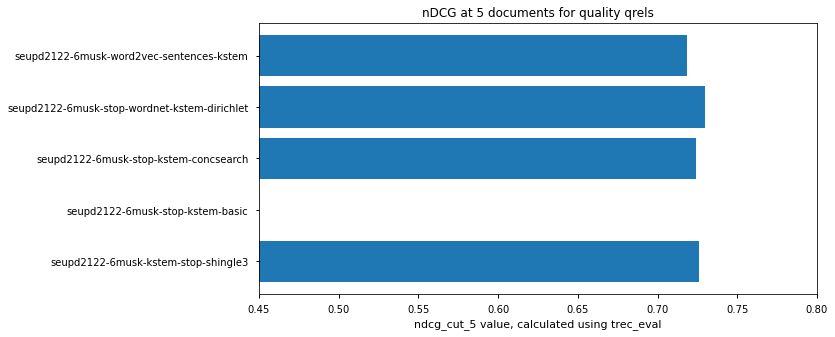

In [31]:
# Plot map and ndcg5 values for all runs for quality qrels

plt.style.use("seaborn-notebook")

df_map_and_ndcg_cut_5, df_ipr = get_results_runs(res_dir, 'quality')

#df_temp = df_map_and_ndcg_cut_5.sort_values('map')
df_temp = df_map_and_ndcg_cut_5.sort_values('runid')
plt.figure(figsize=(10,5))
plt.title(label='Mean Average Precision for quality qrels')
plt.xlim(0.1,0.45)
plt.xlabel(xlabel='map value, calculated using trec_eval')
plt.barh(df_temp.loc[:, 'runid'].to_list(),df_temp.loc[:, 'map'].to_list())
plt.savefig('{res_dir}\\results_map_all_quality.png'.format(res_dir=res_dir), bbox_inches="tight")
plt.show()

#df_temp = df_map_and_ndcg_cut_5.sort_values('ndcg_cut_5')
df_temp = df_map_and_ndcg_cut_5.sort_values('runid')
plt.figure(figsize=(10,5))
plt.title(label='nDCG at 5 documents for quality qrels')
plt.xlim(0.45,0.80)
plt.xlabel(xlabel='ndcg_cut_5 value, calculated using trec_eval')
plt.barh(df_temp.loc[:, 'runid'].to_list(),df_temp.loc[:, 'ndcg_cut_5'].to_list())
plt.savefig('{res_dir}\\results_ndcg5_all_quality.png'.format(res_dir=res_dir), bbox_inches="tight")
plt.show()

### map and ndcg5 val for all runs for relevance qrels

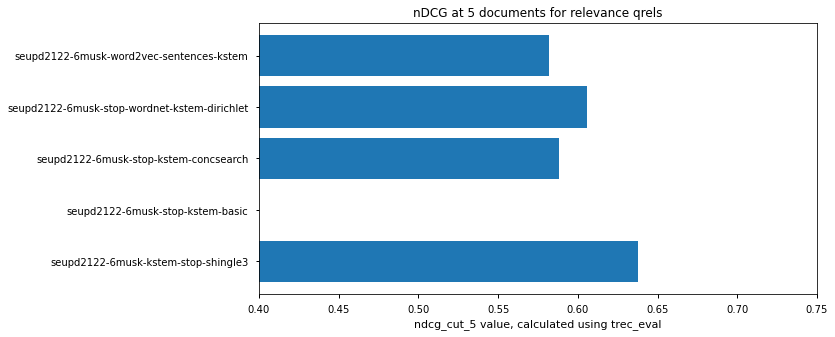

In [32]:
# Plot map and ndcg5 values for all runs for relevance qrels

plt.style.use("seaborn-notebook")

df_map_and_ndcg_cut_5, df_ipr = get_results_runs(res_dir, 'relevance')

#df_temp = df_map_and_ndcg_cut_5.sort_values('map')
df_temp = df_map_and_ndcg_cut_5.sort_values('runid')

plt.figure(figsize=(10,5))
plt.title(label='Mean Average Precision for relevance qrels')
plt.xlim(0.15,0.50)
plt.xlabel(xlabel='map value, calculated using trec_eval')
plt.barh(df_temp.loc[:, 'runid'].to_list(),df_temp.loc[:, 'map'].to_list())
plt.savefig('{res_dir}\\results_map_all_relevance.png'.format(res_dir=res_dir), bbox_inches="tight")
plt.show()

#df_temp = df_map_and_ndcg_cut_5.sort_values('ndcg_cut_5')
df_temp = df_map_and_ndcg_cut_5.sort_values('runid')

plt.figure(figsize=(10,5))
plt.title(label='nDCG at 5 documents for relevance qrels')
plt.xlim(0.40,0.75)
plt.xlabel(xlabel='ndcg_cut_5 value, calculated using trec_eval')
plt.barh(df_temp.loc[:, 'runid'].to_list(),df_temp.loc[:, 'ndcg_cut_5'].to_list())
plt.savefig('{res_dir}\\results_ndcg5_all_relevance.png'.format(res_dir=res_dir), bbox_inches="tight")
plt.show()

### map and ndcg5 val for all runs for coherence qrels

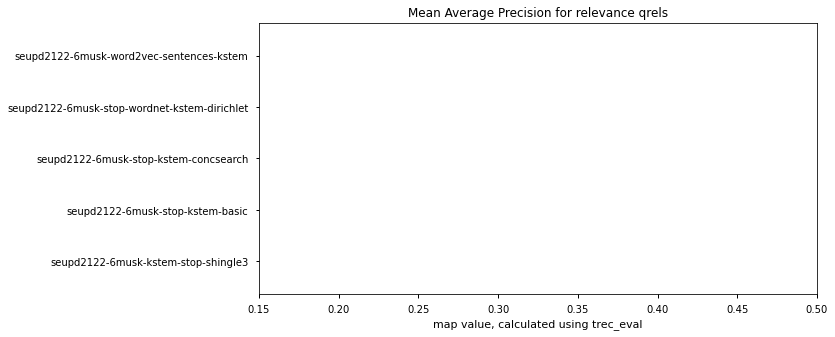

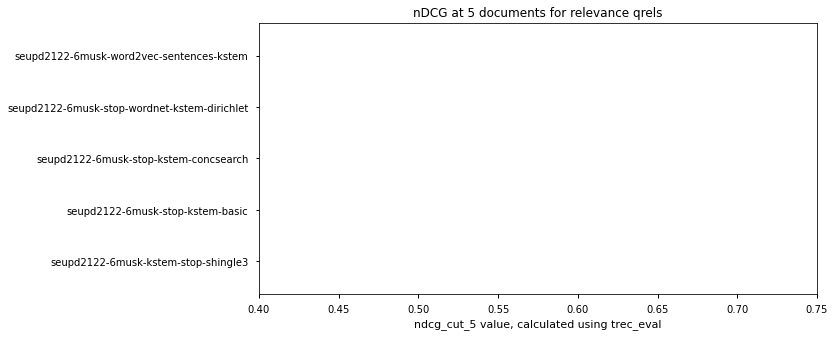

In [33]:
# Plot map and ndcg5 values for all runs for coherence qrels

plt.style.use("seaborn-notebook")

df_map_and_ndcg_cut_5, df_ipr = get_results_runs(res_dir, 'coherence')

#df_temp = df_map_and_ndcg_cut_5.sort_values('map')
df_temp = df_map_and_ndcg_cut_5.sort_values('runid')

plt.figure(figsize=(10,5))
plt.title(label='Mean Average Precision for relevance qrels')
plt.xlim(0.15,0.50)
plt.xlabel(xlabel='map value, calculated using trec_eval')
plt.barh(df_temp.loc[:, 'runid'].to_list(),df_temp.loc[:, 'map'].to_list())
plt.savefig('{res_dir}\\results_map_all_relevance.png'.format(res_dir=res_dir), bbox_inches="tight")
plt.show()

#df_temp = df_map_and_ndcg_cut_5.sort_values('ndcg_cut_5')
df_temp = df_map_and_ndcg_cut_5.sort_values('runid')

plt.figure(figsize=(10,5))
plt.title(label='nDCG at 5 documents for relevance qrels')
plt.xlim(0.40,0.75)
plt.xlabel(xlabel='ndcg_cut_5 value, calculated using trec_eval')
plt.barh(df_temp.loc[:, 'runid'].to_list(),df_temp.loc[:, 'ndcg_cut_5'].to_list())
plt.savefig('{res_dir}\\results_ndcg5_all_relevance.png'.format(res_dir=res_dir), bbox_inches="tight")
plt.show()

### precision-recall curve for quality qrels

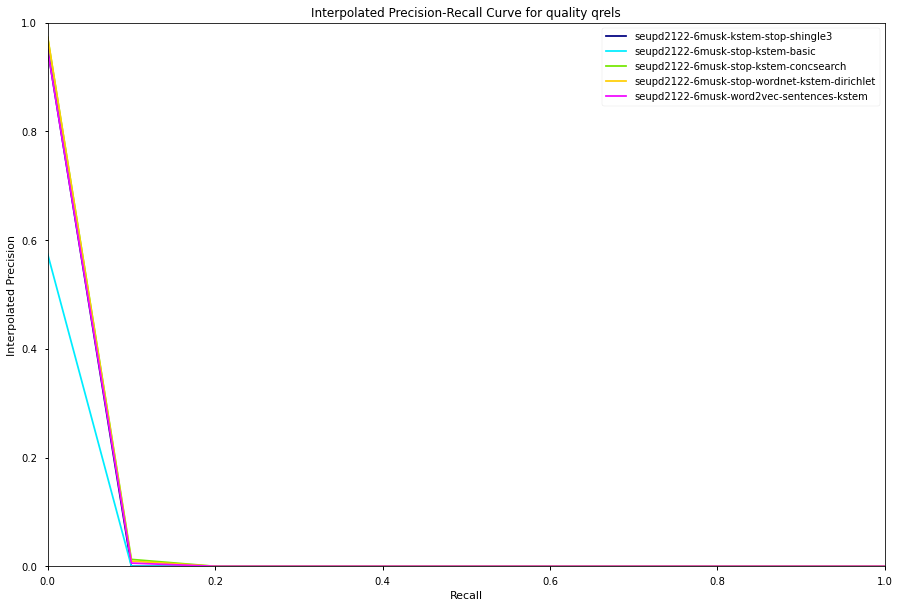

In [34]:
# Plot precision-recall curve for quality qrels

df_map_and_ndcg_cut_5, df_ipr = get_results_runs(res_dir, 'quality')

plt.style.use("seaborn-notebook")

plt.figure(figsize=(15,10))
plt.title(label='Interpolated Precision-Recall Curve for quality qrels')
plt.ylabel(ylabel='Interpolated Precision')
plt.xlabel(xlabel='Recall')
plt.ylim(0.0,1.0)
plt.xlim(0.0,1.0)

#print(df_ipr)
df_temp = df_ipr.set_index(['runid'])
cmap = plt.cm.get_cmap('gist_ncar', int(len(df_temp.index) * 1.2)) #get one color for each run; 
#print(df_ipr)
i = 0
for index, row in df_temp.iterrows():
    #print(index)
    #print(row) 
   
    precision = row.to_numpy()
    recall = np.arange(0.0,1.1,0.1)
    #print(precision)
    #print(recall)

    plt.plot(recall, precision, label=index, color=cmap(i))
    i = i + 1
    
plt.legend()

plt.savefig('{res_dir}\\results_ipr_all_quality.png'.format(res_dir=res_dir), bbox_inches="tight")
plt.show()


### precision-recall curve for relevance qrels

In [35]:
# Plot precision-recall curve for relevance qrels

df_map_and_ndcg_cut_5, df_ipr = get_results_runs(res_dir, 'relevance')

plt.style.use("seaborn-notebook")

plt.figure(figsize=(15,10))
plt.title(label='Interpolated Precision-Recall Curve for relevance qrels')
plt.ylabel(ylabel='Interpolated Precision')
plt.xlabel(xlabel='Recall')
plt.ylim(0.0,1.0)
plt.xlim(0.0,1.0)

#print(df_ipr)
cmap = plt.cm.get_cmap('gist_ncar', int(len(df_temp.index) * 1.2)) #get one color for each run; 
#print(df_ipr)
i = 0
for index, row in df_temp.iterrows():
    #print(index)
    #print(row) 
   
    precision = row.to_numpy()
    recall = np.arange(0.0,1.1,0.1)
    #print(precision)
    #print(recall)

    plt.plot(recall, precision, label=index, color=cmap(i))
    i = i + 1
    
plt.legend()

plt.savefig('{res_dir}\\results_ipr_all_relevance.png'.format(res_dir=res_dir), bbox_inches="tight")
plt.show()


### precision-recall curve for coherence qrels

In [36]:
# Plot precision-recall curve for coherence qrels
df_map_and_ndcg_cut_5, df_ipr = get_results_runs(res_dir, 'coherence')

plt.style.use("seaborn-notebook")

plt.figure(figsize=(15,10))
plt.title(label='Interpolated Precision-Recall Curve for coherence qrels')
plt.ylabel(ylabel='Interpolated Precision')
plt.xlabel(xlabel='Recall')
plt.ylim(0.0,1.0)
plt.xlim(0.0,1.0)

#print(df_ipr)
cmap = plt.cm.get_cmap('gist_ncar', int(len(df_temp.index) * 1.2)) #get one color for each run; 
#print(df_ipr)
i = 0
for index, row in df_temp.iterrows():
    #print(index)
    #print(row) 
   
    precision = row.to_numpy()
    recall = np.arange(0.0,1.1,0.1)
    #print(precision)
    #print(recall)

    plt.plot(recall, precision, label=index, color=cmap(i))
    i = i + 1
    
plt.legend()

plt.savefig('{res_dir}\\results_ipr_all_relevance.png'.format(res_dir=res_dir), bbox_inches="tight")
plt.show()
